# **Imports and Constants**

In [1]:
#imports
from __future__ import print_function
from pyspark import SparkContext
from pyspark.ml.clustering import KMeans, KMeansModel
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler, StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SQLContext
from pyspark.sql import SparkSession
from mpl_toolkits.mplot3d import Axes3D
from pyspark.sql.functions import col
from functools import reduce
from pyspark import SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, split, size, isnan, array_contains, array_min, when, count, pandas_udf, PandasUDFType
from pyspark.sql.types import *
import pyspark.sql.functions as f
import matplotlib.pyplot as plt
import pandas as pd 
import glob
import re
import pathlib
import json
import datetime
import numpy as np
import time
import os
import random
import statistics

#env variables
%env PYSPARK_DRIVER_PYTHON=python3.6 
%env PYSPARK_PYTHON=python3.6 

#incompatibility with Pyarrow
#need to install Pyarrow 0.14.1 or lower or Set the environment variable ARROW_PRE_0_15_IPC_FORMAT=1
%env ARROW_PRE_0_15_IPC_FORMAT=1 

#used versions: 
#spark='2.4.3' python='3.6' pyarrow='0.14.1' 

env: PYSPARK_DRIVER_PYTHON=python3.6
env: PYSPARK_PYTHON=python3.6
env: ARROW_PRE_0_15_IPC_FORMAT=1


In [2]:
#paths
DATASET_PATH='/Users/Soroush/Desktop/Thesis/Code/dataset/'

#from google.colab import drive
#drive.mount('/gdrive')

# **Load/Save Dataset**

In [3]:
#load and save .read_pickle() and .to_pickle() 

#save
#dataset.to_pickle(DATASET_PATH+"dataset.pkl")
#aggregated_dataset.to_pickle(DATASET_PATH+"aggregated_dataset.pkl")
#json_dataset.to_pickle(DATASET_PATH+"json_dataset.pkl")
#dataset.to_csv(DATASET_PATH+"dataset.csv")
#aggregated_dataset.to_csv(DATASET_PATH+"aggregated_dataset.csv")
#json_dataset.to_csv(DATASET_PATH+"json_dataset.csv")
#aggregated_dataset_rowBased.to_csv(DATASET_PATH+"aggregated_dataset_rowBased.csv")


#load
dataset=pd.read_pickle(DATASET_PATH+"dataset.pkl")
aggregated_dataset=pd.read_pickle(DATASET_PATH+"aggregated_dataset.pkl")
json_dataset=pd.read_pickle(DATASET_PATH+"json_dataset.pkl")

# **Malicious Samples**

In [4]:
# Generate malicious samples
def h1(x):
    MAX=0.8
    MIN=0.1
    alpha=random.uniform(MIN,MAX)
    temp=np.array(x)
    return (temp*alpha).tolist()

def h2(x):
    MIN_OFF=4 # hour
    DURATION=random.randint(MIN_OFF,23)
    START=random.randint(0,23-DURATION) if DURATION!=23 else 0
    END=START+DURATION
    temp=[]
    for i in range(len(x)):
        if i<START or i>=END:
            temp.append(x[i])
        else:
            temp.append(0.0)
    return temp
    
def h3(x):
    MAX=0.8
    MIN=0.1
    temp=[]
    for i in range(len(x)):
        temp.append(x[i]*random.uniform(MIN,MAX))
    return temp

def h4(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean*random.uniform(MIN,MAX))
    return temp

def h5(x):
    MAX=0.8
    MIN=0.1
    mean=np.mean(x)
    temp=[]
    for i in range(len(x)):
        temp.append(mean)
    return temp

def h6(x):
    temp=np.array(x)
    #temp=temp[::-1] 
    temp=np.flipud(temp) 
    return temp.tolist()

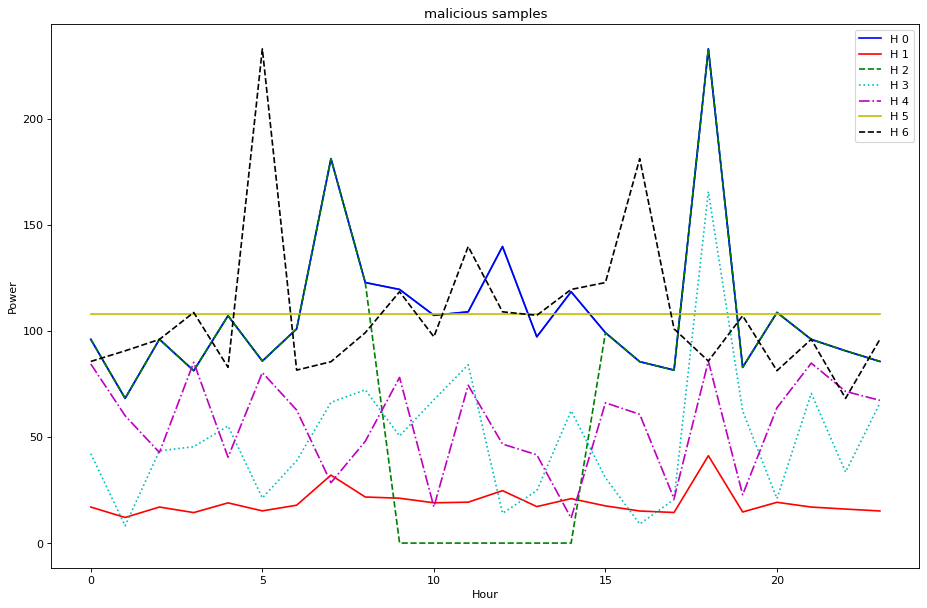

In [5]:
#plot
read_value=[96.00396728515625, 68.20671844482422, 96.05184936523438, 81.24053192138672, 107.14600372314453, 85.7899169921875, 100.9619140625, 181.16192626953125, 122.7833023071289, 119.53163146972656, 107.34815216064453, 108.99268341064453, 139.76922607421875, 97.21031951904297, 118.4515151977539, 99.15070343017578, 85.47505187988281, 81.51718139648438, 232.91493225097656, 82.83419799804688, 108.6827163696289, 95.99102020263672, 90.59868621826172, 85.60449981689453]
lists=[]
colors=['b','r-','g--','c:','m-.','y-','k--']
lists.append(read_value)
lists.append(h1(read_value))
lists.append(h2(read_value))
lists.append(h3(read_value))
lists.append(h4(read_value))
lists.append(h5(read_value))
lists.append(h6(read_value))
plt.figure(num=None, figsize=(14, 9), dpi=80, facecolor='w', edgecolor='k')
plt.xlabel("Hour")
plt.ylabel("Power")
plt.title("malicious samples")
plt.plot(read_value)
for i in range(len(lists)):
    plt.plot(lists[i],colors[i],label = 'H %s'%i)
plt.legend()
plt.show()

# **Prepare Spark Dataset**

In [20]:
#create SparkSession
spark = SparkSession.builder.appName("anomaly_detection").master("local[2]").getOrCreate()
#network problem? type it in commandline: sudo hostname -s 127.0.0.1

#define schema
schema = StructType([
    StructField("#", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
    StructField("power", StringType())])

#read data
sdf = spark.read.format('csv').options(header='true',inferSchema=True ,schema=schema).load(DATASET_PATH+"aggregated_dataset_rowBased.csv")

#rename columns
def rename_dataframe(sdf):
    names = ['#','date','id','power']
    for c,n in zip(sdf.columns,names):
        sdf=sdf.withColumnRenamed(c,n)
    return sdf
    
sdf=rename_dataframe(sdf)
#sdf.show()
    
#convert power to array
def string_power_to_array(sdf):
    temp=sdf.withColumn("power", f.regexp_replace(f.regexp_replace(f.col("power"), "\\[", ""),"\\]","")
                        .alias("power"))
    temp=temp.withColumn("power",split(col("power"), ",\s*")
                        .cast(ArrayType(FloatType())).alias("power"))
    return temp

sdf=string_power_to_array(sdf)
#sdf.show()

#add "v"alidation column
# old code based on spark functions
#def add_validation_column(sdf):
#    v=True
#    temp=sdf.withColumn("V",f.when((size(sdf.power)==24) #array size
#                                   & ~(f.array_contains(sdf.power, float('nan'))) #containing NaN
#                                   & ~(f.array_max(sdf.power)<=0) #all 0
#                                   , True).otherwise(False))
#    return temp

def add_validation_column(sdf):
    def validation(x):
        res=[]
        for row in x:
            v=True
            if (len(row)!= 24 or # unusual size
                (row>=0).sum()!=24 or #number of valid elements = 24
                #sum(n >= 0 for n in row) != 24 or 
                np.count_nonzero(row == 0)>=3 or #equal or more than 3 zero elements
                sum(n < 0 for n in row) > 0): #not have negative element
                    v=False
            res.append(v)
        return pd.Series(res)
    validation_UDF = pandas_udf(validation, returnType=BooleanType())
    temp=sdf.withColumn("V",validation_UDF(col("power")))
    return temp

sdf=add_validation_column(sdf)
#sdf.show()


#add "N"ormal consumption ("N"onmalicious) column
def add_Normal_column(sdf):
    N=True
    temp=sdf.withColumn("N", f.lit(N))
    return temp

sdf=add_Normal_column(sdf)
#sdf.show()

#filter data
def filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="*",V="*"):
    temp=sdf
    if (from_date!="BEGIN"):
        temp=temp.filter(sdf.date > from_date) #filter date (from X)
    if (to_date!="END"):
        temp=temp.filter(sdf.date < to_date) #filter date (to Y)
    if (ID!="*"):
        temp=temp.filter(sdf.id == ID) #filter IDs
    if (V!="*"):
        temp=temp.filter(sdf.V == V) #filter validation    
    return temp

sdf=filter_dataset(sdf,from_date="BEGIN",to_date="END",ID="Apt36",V="True")
#sdf.show()

def split_power(sdf):
    temp=sdf.select("#","date","id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
    return temp
    
#split_sdf=split_power(sdf)
#sdf.show()


sdf.show()
print("number of rows: " + str(sdf.count()))
#sdf.collect()
#sdf.printSchema()
#split_sdf=add_validation_column(split_sdf)

+---+-------------------+-----+--------------------+----+----+
|  #|               date|   id|               power|   V|   N|
+---+-------------------+-----+--------------------+----+----+
|  0|2014-08-15 00:00:00|Apt36|[1.96932, 0.38400...|true|true|
|  1|2014-08-16 00:00:00|Apt36|[0.61410224, 0.44...|true|true|
|  2|2014-08-17 00:00:00|Apt36|[1.3780422, 1.165...|true|true|
|  3|2014-08-18 00:00:00|Apt36|[1.1634789, 2.013...|true|true|
|  4|2014-08-19 00:00:00|Apt36|[1.1126077, 1.294...|true|true|
|  5|2014-08-20 00:00:00|Apt36|[1.4072489, 1.076...|true|true|
|  6|2014-08-21 00:00:00|Apt36|[1.4892989, 1.260...|true|true|
|  7|2014-08-22 00:00:00|Apt36|[0.5883856, 0.554...|true|true|
|  8|2014-08-23 00:00:00|Apt36|[0.52373445, 1.48...|true|true|
|  9|2014-08-24 00:00:00|Apt36|[0.39280555, 1.30...|true|true|
| 10|2014-08-25 00:00:00|Apt36|[0.4686211, 0.502...|true|true|
| 11|2014-08-26 00:00:00|Apt36|[1.2439622, 0.637...|true|true|
| 12|2014-08-27 00:00:00|Apt36|[1.8882623, 2.731...|tru

In [21]:
#add malicious samples
def create_malicious_df(sdf):
    def random_attack_assigner(x):
        NUMBER_OF_MALICIOUS_GENERATOR=6
        res=[]
        for row in x:
            rand = random.randint(1,NUMBER_OF_MALICIOUS_GENERATOR)
            if rand==1:
                temp=(h1(row))
            elif rand==2:
                temp=(h2(row))
            elif rand==3:
                temp=(h3(row))
            elif rand==4:
                temp=(h4(row))
            elif rand==5:
                temp=(h5(row))
            elif rand==6:
                temp=(h6(row))
            res.append(temp)
        return pd.Series(res)
    random_attack_assigner_UDF = pandas_udf(random_attack_assigner, returnType=ArrayType(FloatType()))
    sdf_malicious=sdf
    N=False
    sdf_malicious=sdf_malicious.withColumn("N", f.lit(N)) #malicious sample
    sdf_malicious=sdf_malicious.withColumn("#", col("#")*-1) # change '#' column number to negative
    sdf_malicious=sdf_malicious.withColumn("power",random_attack_assigner_UDF(col("power")))
    return sdf_malicious
sdf.printSchema()
print("benign dataframe (sdf):")
sdf.show()
sdf_malicious=create_malicious_df(sdf)
print("malicious dataframe (sdf_malicious):")
sdf_malicious.show()
final_sdf= sdf.union(sdf_malicious)
print("final dataframe (final_sdf):")
final_sdf.show()


root
 |-- #: integer (nullable = true)
 |-- date: timestamp (nullable = true)
 |-- id: string (nullable = true)
 |-- power: array (nullable = true)
 |    |-- element: float (containsNull = true)
 |-- V: boolean (nullable = true)
 |-- N: boolean (nullable = false)

benign dataframe (sdf):
+---+-------------------+-----+--------------------+----+----+
|  #|               date|   id|               power|   V|   N|
+---+-------------------+-----+--------------------+----+----+
|  0|2014-08-15 00:00:00|Apt36|[1.96932, 0.38400...|true|true|
|  1|2014-08-16 00:00:00|Apt36|[0.61410224, 0.44...|true|true|
|  2|2014-08-17 00:00:00|Apt36|[1.3780422, 1.165...|true|true|
|  3|2014-08-18 00:00:00|Apt36|[1.1634789, 2.013...|true|true|
|  4|2014-08-19 00:00:00|Apt36|[1.1126077, 1.294...|true|true|
|  5|2014-08-20 00:00:00|Apt36|[1.4072489, 1.076...|true|true|
|  6|2014-08-21 00:00:00|Apt36|[1.4892989, 1.260...|true|true|
|  7|2014-08-22 00:00:00|Apt36|[0.5883856, 0.554...|true|true|
|  8|2014-08-23 00

# **K-Means**

In [7]:
def prepare_for_kmeans(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #generate uniqe id
    def generate_uniqe_id(sdf):
        temp=sdf
        temp=temp.withColumn("uid",f.concat(col("id"),f.lit("-"),col("#")).alias("uid"))
        return temp
    
    #call the generate_uniqe_id function
    temp=generate_uniqe_id(temp)
    
    #make ready
    vecAssembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    return df_kmeans

#Loads data
sdf_kmeans=prepare_for_kmeans(sdf) # replace sdf with final_sdf for clustring benign and malicious data

print("prepared dataframe for k-means (sdf_kmeans):")
sdf_kmeans.show()
sdf_kmeans.printSchema()
print("number of rows: " + str(sdf_kmeans.count()))

prepared dataframe for k-means (sdf_kmeans):
+--------+--------------------+
|      id|            features|
+--------+--------------------+
| Apt36-0|[1.96932005882263...|
| Apt36-1|[0.61410224437713...|
| Apt36-2|[1.37804222106933...|
| Apt36-3|[1.16347885131835...|
| Apt36-4|[1.11260771751403...|
| Apt36-5|[1.40724885463714...|
| Apt36-6|[1.48929893970489...|
| Apt36-7|[0.58838558197021...|
| Apt36-8|[0.52373445034027...|
| Apt36-9|[0.39280554652214...|
|Apt36-10|[0.46862110495567...|
|Apt36-11|[1.24396216869354...|
|Apt36-12|[1.88826227188110...|
|Apt36-13|[1.29602003097534...|
|Apt36-14|[1.33855450153350...|
|Apt36-15|[1.77084887027740...|
|Apt36-16|[1.10214221477508...|
|Apt36-17|[2.55455994606018...|
|Apt36-18|[0.40944999456405...|
|Apt36-19|[1.64525449275970...|
+--------+--------------------+
only showing top 20 rows

root
 |-- id: string (nullable = true)
 |-- features: vector (nullable = true)

number of rows: 87756


In [8]:
#run k-means

def kmeans(sdf_kmeans):
    #find best k
    MAX_k=5
    costs = np.zeros(MAX_k)
    silhouettes = np.zeros(MAX_k)
    silhouettes[1]=0 #set value for k=1
    for k in range(2,MAX_k):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(sdf_kmeans)
        costs[k] = model.computeCost(sdf_kmeans) # requires Spark 2.0 or later
        predictions = model.transform(sdf_kmeans)
        evaluator = ClusteringEvaluator()
        silhouettes[k] = evaluator.evaluate(predictions)

    #show silhouette
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(2,MAX_k),silhouettes[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('silhouette')

    #show cost
    fig, ax = plt.subplots(1,1, figsize =(8,6))
    ax.plot(range(2,MAX_k),costs[2:MAX_k])
    ax.set_xlabel('k')
    ax.set_ylabel('cost')

    # find best k
    best_k = np.argmax(silhouettes)
    print("maximum value of silhouette is: " + str(silhouettes[best_k]) + " in index: " + str(best_k) )

    # Trains a k-means model.
    kmeans = KMeans().setK(best_k).setSeed(1)
    model = kmeans.fit(sdf_kmeans)

    # Make predictions
    predictions = model.transform(sdf_kmeans)

    # Evaluate clustering by computing Silhouette score
    evaluator = ClusteringEvaluator()

    silhouette = evaluator.evaluate(predictions)
    print("Silhouette with squared euclidean distance = " + str(silhouette))

    # Shows the result.
    centers = model.clusterCenters()
    print("Cluster Centers: ")
    for center in centers:
        print(center)

    #transformed = model.transform(sdf_kmeans).select('id', 'prediction')
    #transformed.show()
    #transformed.groupby('prediction').count().show()
    #rows = transformed.collect() 
    #prediction = spark.createDataFrame(rows)
    #prediction.show()
    return model


In [ ]:
#call k-means for all ids

#get id list
def get_ids(sdf):
    IDs=np.array(sdf.select("id").distinct().collect())
    IDs=IDs.reshape(1,len(IDs))
    return IDs

id_list=get_ids(sdf)

for i in np.nditer(id_list):
    check=0
    if check==0:
        sdf_kmeans_by_id=sdf_kmeans.filter(sdf_kmeans.id.like(str(i)+"-"+"%")) #filter IDs
        print(str(i))
        sdf_kmeans_by_id.show()
        kmeans_model=kmeans(sdf_kmeans_by_id)
        kmeans_model.save("kmeans models/"+str(i))
        #model_name = KMeansModel.load("kmeans models/"+str(i)) #for load model
    check+=1


In [ ]:
#call k-means for 1 id

sdf_kmeans_by_id=sdf_kmeans.filter(sdf_kmeans.id.like("Apt36"+"-"+"%")) #filter IDs
sdf_kmeans_by_id.show()
print("number of rows: " + str(sdf_kmeans_by_id.count()))

# Trains a k-means model.
kmeans = KMeans().setK(2).setSeed(1)
model = kmeans.fit(sdf_kmeans_by_id)

# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

# Shows the result.
centers = model.clusterCenters()
print("Cluster Centers: ")
for center in centers:
    print(center)

# **Decision Tree Methods**

In [22]:
def prepare_for_decision_tree_methods(sdf): 
    
    temp=sdf
    
    #define function for split power column
    def split_power(sdf):
        temp=sdf.select("#", "V", "N", "date", "id",
           sdf.power[0].alias("H0"), sdf.power[1].alias("H1"), sdf.power[2].alias("H2"),sdf.power[3].alias("H3"),
           sdf.power[4].alias("H4"), sdf.power[5].alias("H5"), sdf.power[6].alias("H6"),sdf.power[7].alias("H7"),
           sdf.power[8].alias("H8"), sdf.power[9].alias("H9"), sdf.power[10].alias("H10"),sdf.power[11].alias("H11"),
           sdf.power[12].alias("H12"), sdf.power[13].alias("H13"), sdf.power[14].alias("H14"),sdf.power[15].alias("H15"),
           sdf.power[16].alias("H16"), sdf.power[17].alias("H17"), sdf.power[18].alias("H18"),sdf.power[19].alias("H19"),
           sdf.power[20].alias("H20"), sdf.power[21].alias("H21"), sdf.power[22].alias("H22"),sdf.power[23].alias("H23"))
        return temp
    
    #call the split_power function
    temp=split_power(temp)
    
    #boolean to string (for "N" column)
    temp=temp.withColumn("N",f.col("N").cast('string'))
    #temp.printSchema()
    
    
    #filter date
    #temp=temp.filter(temp.date > "2014-08-15").filter(temp.date < "2014-08-19") #filter dates
    #temp=temp.filter(temp.id == "Apt40") #filter IDs
    temp=temp.filter(temp.V==True) #filter valid rows
    
    FEATURES = ['H0', 'H1', 'H2','H3', 'H4', 'H5','H6', 'H7', 'H8','H9', 'H10', 'H11',
            'H12', 'H13', 'H14','H15', 'H16', 'H17','H18', 'H19', 'H20','H21', 'H22', 'H23']
    
    #generate uniqe id
    def generate_uniqe_id(sdf):
        temp=sdf
        temp=temp.withColumn("uid",f.concat(col("id"),f.lit("-"),col("#")).alias("uid"))
        return temp
    
    #call the generate_uniqe_id function
    #temp=generate_uniqe_id(temp)
    
    #make features ready
    assembler = VectorAssembler(inputCols=FEATURES, outputCol="features")
    output = assembler.transform(temp)
    #df_kmeans = vecAssembler.transform(temp).select(col("uid").alias("id"), col("features"))
    
    #make label ready
    indexer = StringIndexer(inputCol="N", outputCol="NIndex")
    output_fixed = indexer.fit(output).transform(output)
    
    final_data = output_fixed.select("features",'NIndex')
    return final_data

#prepare data
tree_data=prepare_for_decision_tree_methods(final_sdf)
train_data,test_data = tree_data.randomSplit([0.7,0.3])

print("prepared dataframe for decision tree methods:")
tree_data.show()
tree_data.printSchema()
print("number of rows: " + str(tree_data.count()))


prepared dataframe for decision tree methods:
+--------------------+------+
|            features|NIndex|
+--------------------+------+
|[1.96932005882263...|   0.0|
|[0.61410224437713...|   0.0|
|[1.37804222106933...|   0.0|
|[1.16347885131835...|   0.0|
|[1.11260771751403...|   0.0|
|[1.40724885463714...|   0.0|
|[1.48929893970489...|   0.0|
|[0.58838558197021...|   0.0|
|[0.52373445034027...|   0.0|
|[0.39280554652214...|   0.0|
|[0.46862110495567...|   0.0|
|[1.24396216869354...|   0.0|
|[1.88826227188110...|   0.0|
|[1.29602003097534...|   0.0|
|[1.33855450153350...|   0.0|
|[1.77084887027740...|   0.0|
|[1.10214221477508...|   0.0|
|[2.55455994606018...|   0.0|
|[0.40944999456405...|   0.0|
|[1.64525449275970...|   0.0|
+--------------------+------+
only showing top 20 rows

root
 |-- features: vector (nullable = true)
 |-- NIndex: double (nullable = false)

number of rows: 1644


# **TEST**

# **Useful Commands**

In [ ]:
#.describe().show()
#.printSchema()
#.collect()
#.count()

# **Other**

In [ ]:
#create json data from stored dataframe

def to_json(final):
    PERIOD=60

    data_for_json=final.loc[:, final.columns != 'date']

    def date_to_str(o):
        if isinstance(o, datetime.datetime):
            return o.__str__()

    json_dataframe = pd.DataFrame(columns=['data']) #creates a new dataframe that's empty
    L  = []

    import json
    import datetime
    import time

    r, c = data_for_json.shape
    for i in range(0, r):
        for j in range(0, c):
            data = {}
            data['id'] = data_for_json.columns.values[j]
            data['power'] = data_for_json.iloc[i][j]
            data['date']=data_for_json.index.tolist()[i]
            json_data = json.dumps(data,default=date_to_str)
            L.append(json_data)
            #json_dataframe=json_dataframe.append(json_data,ignore_index=True)

    json_dataframe = pd.DataFrame(L, columns=['data'])
    return json_dataframe

In [ ]:
#load by schema

schema = StructType([
  StructField("num", IntegerType()),
    StructField("date", TimestampType()),
    StructField("id", StringType()),
  StructField("power", ArrayType(
      StructType([
          StructField("H0", FloatType(), True),
          StructField("H1", FloatType(), True),
          StructField("H2", FloatType(), True),
          StructField("H3", FloatType(), True),
          StructField("H4", FloatType(), True),
          StructField("H5", FloatType(), True),
          StructField("H6", FloatType(), True),
          StructField("H7", FloatType(), True),
          StructField("H8", FloatType(), True),
          StructField("H9", FloatType(), True),
          StructField("H10", FloatType(), True),
          StructField("H11", FloatType(), True),
          StructField("H12", FloatType(), True),
          StructField("H13", FloatType(), True),
          StructField("H14", FloatType(), True),
          StructField("H15", FloatType(), True),
          StructField("H16", FloatType(), True),
          StructField("H17", FloatType(), True),
          StructField("H18", FloatType(), True),
          StructField("H19", FloatType(), True),
          StructField("H20", FloatType(), True),
          StructField("H21", FloatType(), True),
          StructField("H22", FloatType(), True),
          StructField("H23", FloatType(), True)
      ])
   )
             )])

a = spark.read.format('csv').schema(schema).option("header", "true").load(DATASET_PATH+"f.csv")
a.show()

In [ ]:
#test pandas_udf

my_schema = StructType([
    StructField("id", IntegerType()),
    StructField("age", IntegerType())])
df=spark.read.csv("test.csv", header=True,schema=my_schema)
df.show()
df.printSchema()

def plus_one(a):
    return a+1

plus_one_udf = pandas_udf(plus_one, returnType=IntegerType())

df.select(plus_one_udf(col("age"))).show()

In [ ]:
#test pandas_udf (for array input)

df = spark.createDataFrame([([1,2,3,4,5,6],'val1'),([4,5,6,7,8,9],'val2')],['col1','col2'])
df.show()

@pandas_udf(ArrayType(LongType()))
def func(v):
    res=[]
    for row in v:
        temp=[]
        for k in range(len(row)):
            if (k<=2) or (k>4):
                temp.append(row[k])
            else:
                temp.append(row[k]*0)
        res.append(temp)
    return pd.Series(res)

df.withColumn('col3',func(df.col1)).show()